Import

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

Ouverture du fichier csv de data 

In [4]:

df = pd.read_csv("../Data/e_commerce_shopper_behaviour_and_lifestyle.csv")
df.head()

,user_id,age,gender,country,urban_rural,income_level,employment_status,education_level,relationship_status,has_children,...,cart_items_average,checkout_abandonments_per_month,purchase_conversion_rate,app_usage_frequency,notification_response_rate,account_age_months,last_purchase_date,social_sharing_frequency,premium_subscription,return_rate
0,1,56,Female,Germany,Suburban,90860,Self-employed,Associate Degree,Single,0,...,10,2,62,7,74,19,2025-06-22,6,1,50
1,2,69,Male,Japan,Suburban,35423,Unemployed,Bachelor,Single,1,...,5,7,54,5,23,8,2026-07-25,3,0,37
2,3,46,Female,India,Urban,21467,Self-employed,Associate Degree,Married,1,...,3,3,33,7,12,13,2026-02-26,6,0,53
3,4,32,Male,Canada,Urban,41770,Self-employed,Bachelor,Widowed,0,...,5,9,26,4,19,9,2026-10-27,7,0,98
4,5,60,Female,Japan,Urban,183882,Employed,Associate Degree,Widowed,1,...,8,0,18,7,30,3,2026-06-23,3,0,86


In [5]:

print("Nombre de doublons :", df.duplicated().sum())

print("Valeurs nulles par colonne :\n", df.isnull().sum())

Nombre de doublons : 0
Valeurs nulles par colonne :
 user_id                            0
age                                0
gender                             0
country                            0
urban_rural                        0
income_level                       0
employment_status                  0
education_level                    0
relationship_status                0
has_children                       0
household_size                     0
occupation                         0
ethnicity                          0
language_preference                0
device_type                        0
weekly_purchases                   0
monthly_spend                      0
cart_abandonment_rate              0
review_writing_frequency           0
average_order_value                0
preferred_payment_method           0
coupon_usage_frequency             0
loyalty_program_member             0
referral_count                     0
product_category_preference        0
shopping_time_of_day  

Verification outliers

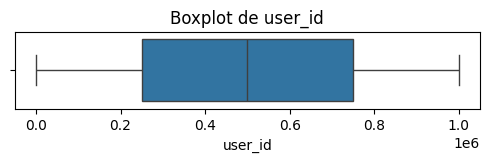

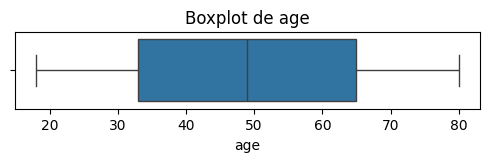

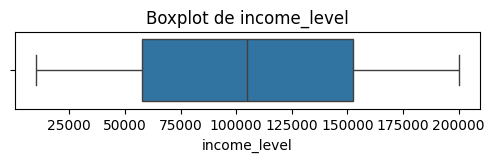

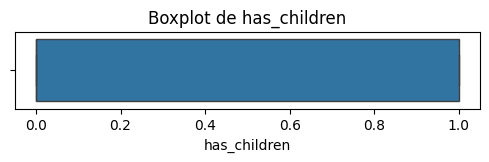

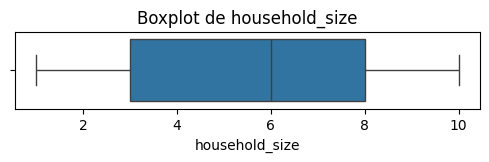

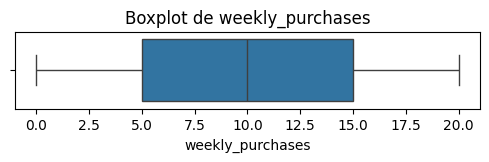

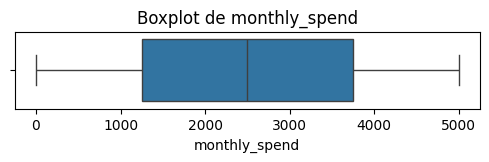

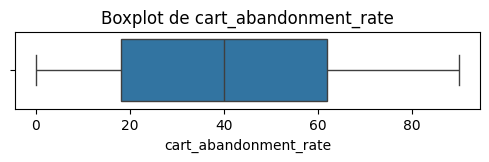

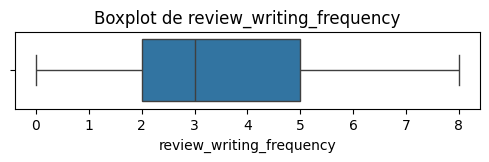

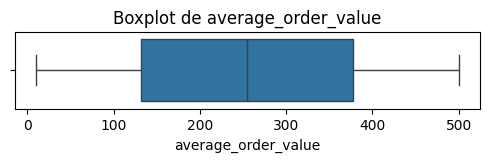

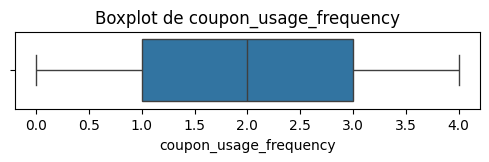

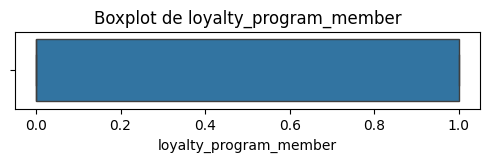

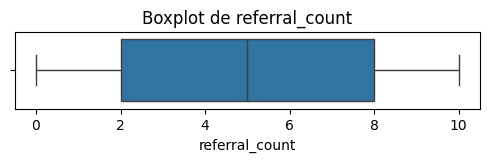

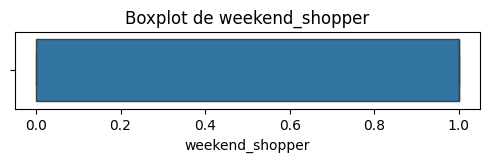

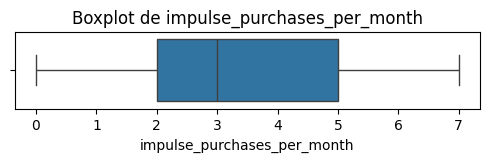

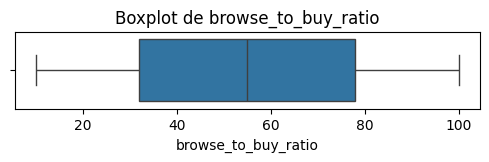

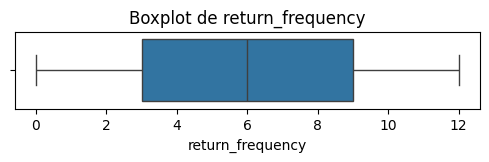

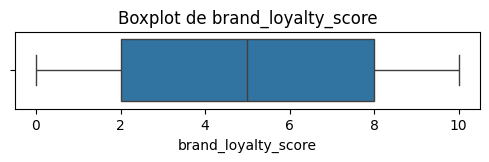

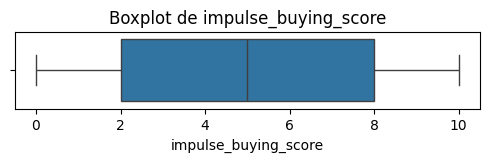

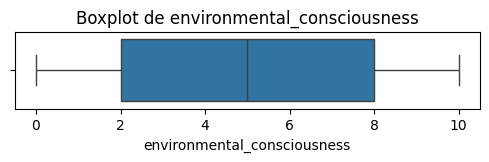

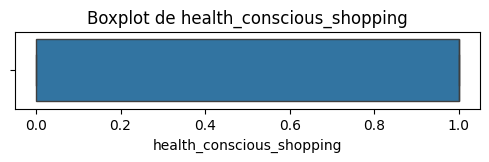

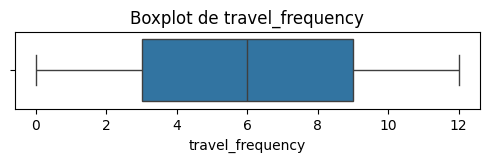

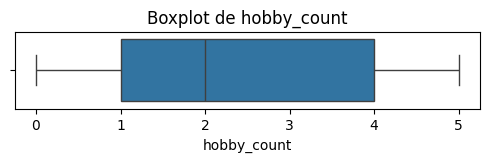

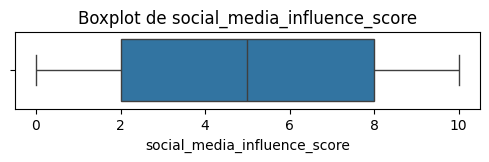

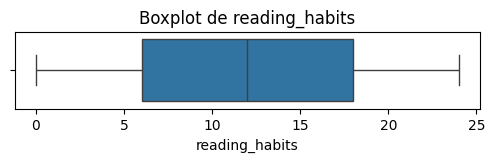

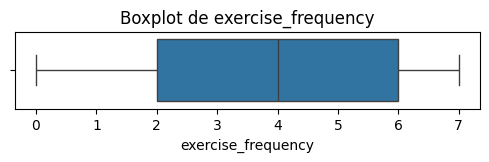

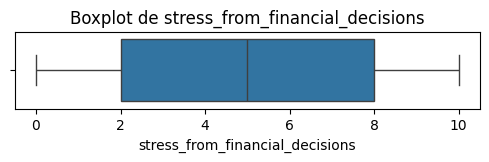

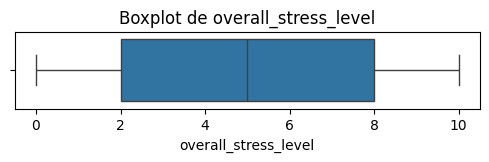

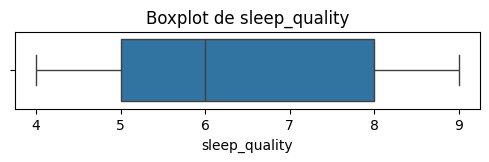

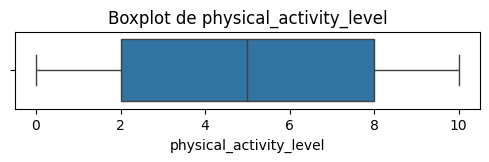

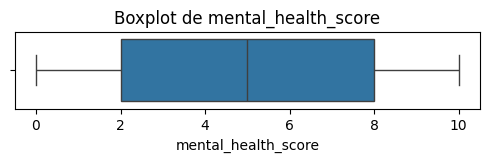

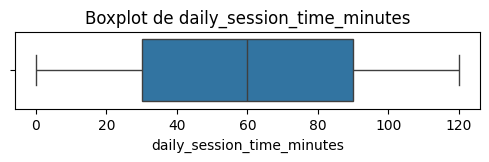

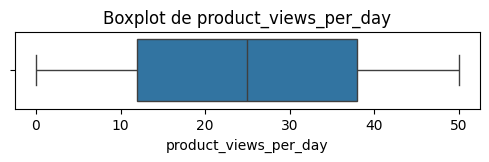

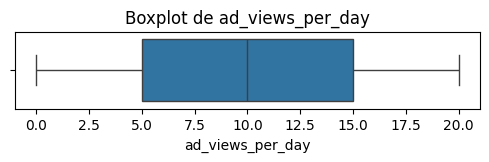

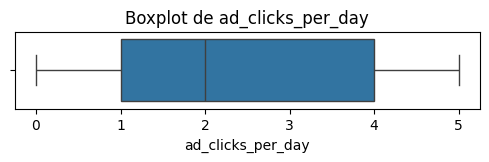

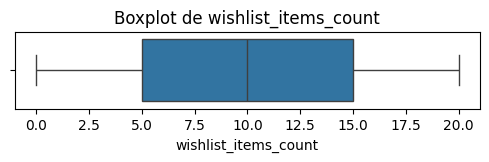

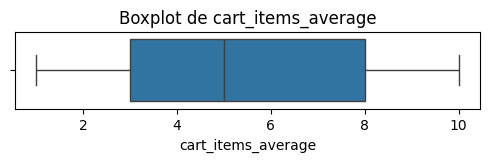

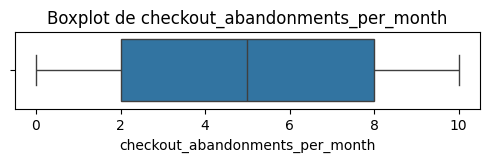

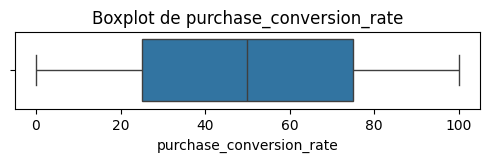

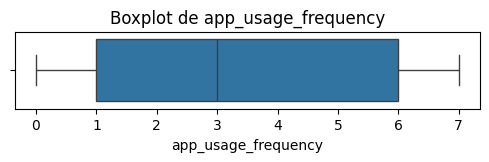

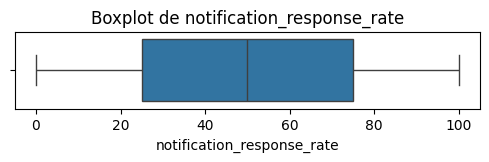

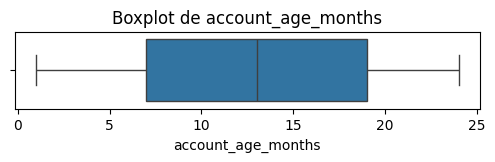

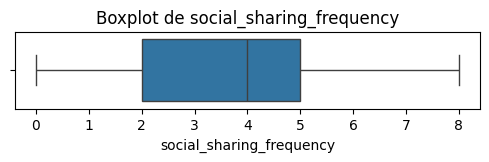

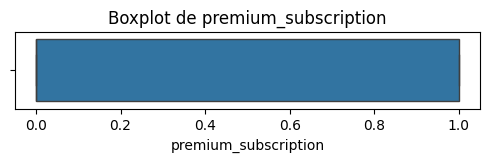

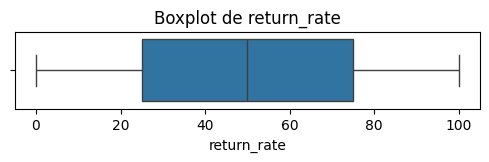

In [6]:
# Vérification des outliers avec des boxplots pour chaque colonne numérique
import matplotlib.pyplot as plt

colonnes_numeriques = df.select_dtypes(include=['float64', 'int64']).columns

for col in colonnes_numeriques:
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

In [8]:
# Suppression de la colonne 'user_id' si elle existe
if 'user_id' in df.columns:
    df = df.drop(columns=['user_id'])

Matrice de corrélation

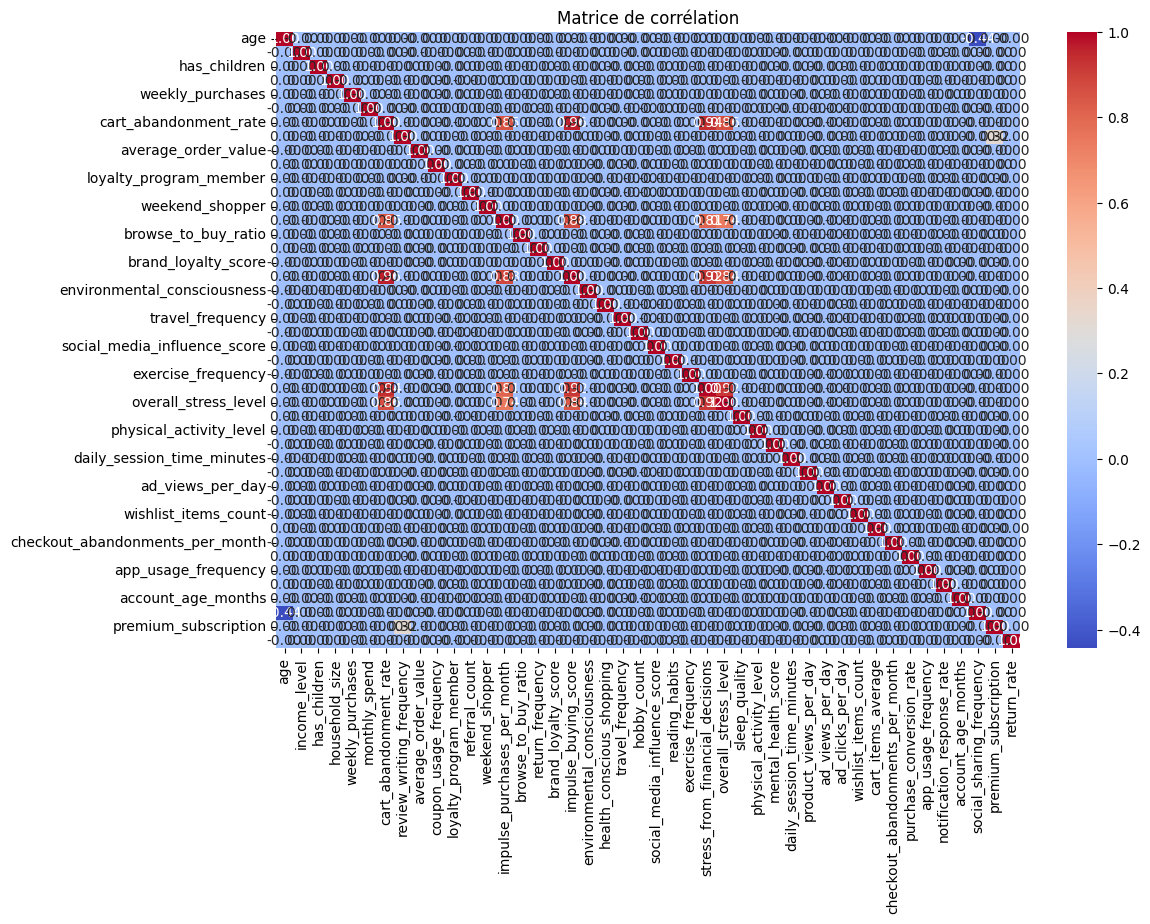

In [9]:

plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()